In [67]:
using Pkg; Pkg.activate("."); 
using StatsBase
using Revise
import MUST
using PyPlot
using Interpolations
using PyCall
using KernelDensity
using DelimitedFiles

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"

MUST.@get_help visual
pl = pyimport("matplotlib.pylab")

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


PyObject <module 'matplotlib.pylab' from '/mpcdf/soft/SLE_12/packages/x86_64/anaconda/3/2021.05/lib/python3.8/site-packages/matplotlib/pylab.py'>

In [68]:
eos_path = "input_data/solar_lte"
eos_path = "input_data/TSO_sun_Magg_v1"
sqEOS    = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

The stagger model to compare with

In [69]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger_TSO", folder=folder_stagger);
stagger_τ      = MUST.Box("box_solar_stagger_TSO_t", folder=folder_stagger);

The different Dispatch models

``TAB_TEFF``: Tabgen EoS, initital temperature modified to get solar Teff

``TAB_TRHO``: Tabgen EoS, initital temperature + density chosen from stagger snapshot to match adiabat

``TSO_TEFF``: TS EoS, initital temperature modified to get solar Teff

``TSO_TRHO``: TS EoS, initital temperature + density chosen from stagger snapshot to match adiabat

In [70]:
folder1 = MUST.@in_dispatch "data/TSO_sun_Magg_rturc"
folder1 = MUST.@in_dispatch "data/TSO_sun_Magg"
folder1 = MUST.@in_dispatch "data/TSO_sun_Magg_longer"
folder1 = MUST.@in_dispatch "data/TSO_sun_Magg_newton"
folder1 = MUST.@in_dispatch "data/TSO_sun_Magg_moreRT"
folder1 = MUST.@in_dispatch "data/TSO_sun_TDZv5.1_v2"
model_tab_teff, model_t_tab_teff = MUST.Boxes(folder1, snaps=[26])

folder2 = MUST.@in_dispatch "data/TAB_sun_profile_hRes"
#folder2 = MUST.@in_dispatch "data/TAB_sun_higherD"
#folder2 = MUST.@in_dispatch "data/TAB_sun_d+03"
#folder2 = MUST.@in_dispatch "data/MIK_sun_profile"
model_tab_trho, model_t_tab_trho = MUST.Boxes(folder2, snaps=[12]);

In [71]:
label1 = "TSO"
label2 = "TAB"

"TAB"

In [72]:
function shift_z!(model)
    optical_surface = MUST.height_where(; τ_ross=1.0)                 # function that interpolates height where lgtau=0
    surf_model      = MUST.reduce_by_column(optical_surface, model);  # Reduce data cube to plane by interp. in height according to optical surface 
    model.z = model.z .- MUST.plane_statistic(mean, surf_model, :z)   # Align the z axis such that the point is at this average depth
end

shift_z! (generic function with 1 method)

In [73]:
#shift_z!(stagger)
#shift_z!(model_tab_teff)
#shift_z!(model_tab_trho);

In [74]:
#optical_surface = MUST.height_where(; τ_ross=1.0)                   # function that interpolates height where lgtau=0
#surf_model      = MUST.reduce_by_column(optical_surface, stagger);  # Reduce data cube to plane by interp. in height according to optical surface 

In [75]:
#optical_surface = MUST.height_where(; τ_ross=1.0)                 # function that interpolates height where lgtau=0
#surf_test       = MUST.reduce_by_column(optical_surface, model_tab_trho);

In [76]:
#plt.imshow(surf_test[:T])

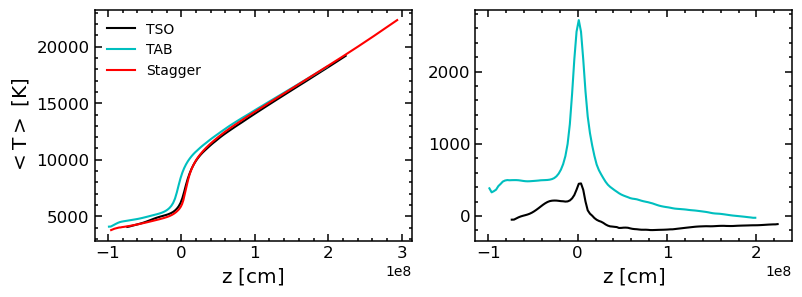

In [77]:
d_tab_teff = MUST.plane_statistic(mean, model_tab_teff, :T)
d_tab_trho = MUST.plane_statistic(mean, model_tab_trho, :T)
d_stagger  = MUST.plane_statistic(mean, stagger, :T)

r_stagger = MUST.plane_statistic(mean, stagger, :d)

z_tab_teff = MUST.axis(model_tab_teff, :z)
z_tab_trho = MUST.axis(model_tab_trho, :z)
z_stagger  = MUST.axis(stagger, :z)

d_ip_tab_teff = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z_tab_teff)
d_ip_tab_trho = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z_tab_trho)


#=dat = zeros(eltype(z_stagger), length(z_stagger), 3)
dat[:, 1] .= z_stagger
dat[:, 2] .= d_stagger
dat[:, 3] .= r_stagger
open("stagger_geo.dat", "w") do f
    writedlm(f, reverse(dat, dims=1))
end=#


# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(9,3))
basic_plot!.(ax)


## The temperature profile
ax[1].plot(-z_tab_teff, d_tab_teff, color="k", label=label1)
ax[1].plot(-z_tab_trho, d_tab_trho, color="c", label=label2)
ax[1].plot(-z_stagger,  d_stagger,  color="r", label="Stagger")

## absolute difference
ax[2].plot(-z_tab_teff, d_tab_teff .- d_ip_tab_teff, color="k", label="Dispatch")
ax[2].plot(-z_tab_trho, d_tab_trho .- d_ip_tab_trho, color="c", label="Dispatch")


ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].legend(framealpha=0, loc="upper left", fontsize="medium");

gcf()

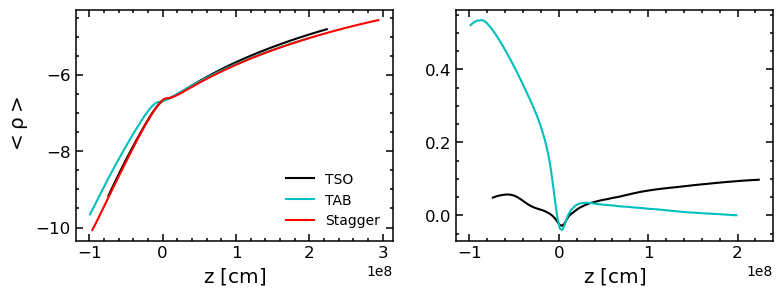

In [78]:
d_tab_teff = log10.(MUST.plane_statistic(mean, model_tab_teff, :d))
d_tab_trho = log10.(MUST.plane_statistic(mean, model_tab_trho, :d))
d_stagger  = log10.(MUST.plane_statistic(mean, stagger, :d))

r_stagger = MUST.plane_statistic(mean, stagger, :d)

z_tab_teff = MUST.axis(model_tab_teff, :z)
z_tab_trho = MUST.axis(model_tab_trho, :z)
z_stagger  = MUST.axis(stagger, :z)

d_ip_tab_teff = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z_tab_teff)
d_ip_tab_trho = Interpolations.linear_interpolation(z_stagger, d_stagger, extrapolation_bc = Line())(z_tab_trho)


#=dat = zeros(eltype(z_stagger), length(z_stagger), 3)
dat[:, 1] .= z_stagger
dat[:, 2] .= d_stagger
dat[:, 3] .= r_stagger
open("stagger_geo.dat", "w") do f
    writedlm(f, reverse(dat, dims=1))
end=#


# Plotting
close()
f, ax = plt.subplots(1, 2, figsize=(9,3))
basic_plot!.(ax)


## The temperature profile
ax[1].plot(-z_tab_teff, d_tab_teff, color="k", label=label1)
ax[1].plot(-z_tab_trho, d_tab_trho, color="c", label=label2)
ax[1].plot(-z_stagger,  d_stagger,  color="r", label="Stagger")

## absolute difference
ax[2].plot(-z_tab_teff, d_tab_teff .- d_ip_tab_teff, color="k", label="Dispatch")
ax[2].plot(-z_tab_trho, d_tab_trho .- d_ip_tab_trho, color="c", label="Dispatch")


ax[1].set_ylabel(L"\rm <\rho>", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

ax[1].legend(framealpha=0, loc="lower right", fontsize="medium");
gcf()

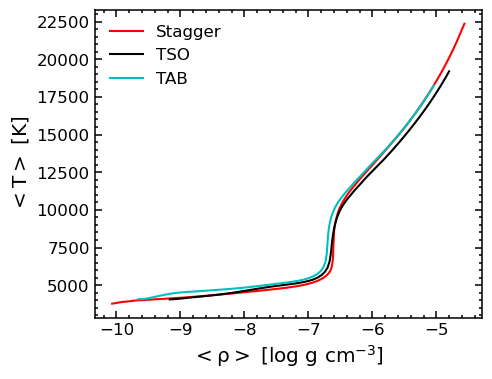

In [79]:
d_tab_teff = MUST.plane_statistic(mean, model_tab_teff, :T)
d_tab_trho = MUST.plane_statistic(mean, model_tab_trho, :T)
d_stagger  = MUST.plane_statistic(mean, stagger, :T)

d2_tab_teff = log10.(MUST.plane_statistic(mean, model_tab_teff, :d))
d2_tab_trho = log10.(MUST.plane_statistic(mean, model_tab_trho, :d))
d2_stagger  = log10.(MUST.plane_statistic(mean, stagger, :d))

# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(5,4))
basic_plot!(ax)


## The temperature profile
ax.plot(d2_stagger,  d_stagger,  color="r", label="Stagger")
ax.plot(d2_tab_teff, d_tab_teff, color="k", label=label1)
ax.plot(d2_tab_trho, d_tab_trho, color="c", label=label2)


ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax.set_xlabel(L"\rm <\rho> \ [log\ g\ cm^{-3}]", fontsize="x-large")

ax.legend(framealpha=0, loc="upper left", fontsize="large");
gcf()

In [80]:
126.6627 * 1e-7

1.2666269999999999e-5

# Comparison on $\tau_{ross}$ scale
Convert the boxes to $\tau_{ross}$ height scale. Do not impose boundaries to avoid extrapolation, let the resolution of the model itself define the limits of the axes.

In [81]:
#stagger_τ  = MUST.height_scale(stagger, :τ_ross)
stagger_τ  = stagger_τ
tab_trho_τ = model_t_tab_trho #MUST.height_scale(model_tab_trho, :τ_ross)
tab_teff_τ = model_t_tab_teff #MUST.height_scale(model_tab_teff, :τ_ross);

In [82]:
#folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
#stagger        = MUST.save(stagger_τ, name="box_solar_stagger_t", folder=folder_stagger);

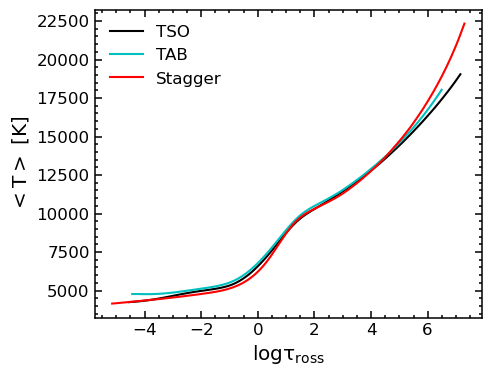

In [83]:
d_tab_teff = MUST.plane_statistic(mean, tab_teff_τ, :T)
d_tab_trho = MUST.plane_statistic(mean, tab_trho_τ, :T)
d_stagger  = MUST.plane_statistic(mean, stagger_τ, :T)

z_tab_teff = log10.(MUST.axis(tab_teff_τ, :τ_ross, 3))
z_tab_trho = log10.(MUST.axis(tab_trho_τ, :τ_ross, 3))
z_stagger  = log10.(MUST.axis(stagger_τ, :τ_ross, 3))

# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(5,4))
basic_plot!(ax)


## The temperature profile
#ax.scatter(log10.(reshape(stagger_τ[:τ_ross], :)), reshape(stagger_τ[:T], :), color="r", s=0.01)
#ax.scatter(log10.(reshape(tab_trho_τ[:τ_ross], :)), reshape(tab_trho_τ[:T], :), color="c", s=0.01)
#ax.scatter(log10.(reshape(tab_teff_τ[:τ_ross], :)), reshape(tab_teff_τ[:T], :), color="k", s=0.01)


ax.plot(z_tab_teff, d_tab_teff, color="k", label=label1)
ax.plot(z_tab_trho, d_tab_trho, color="c", label=label2)
ax.plot(z_stagger,  d_stagger,  color="r", label="Stagger")


ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax.set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")

#ax.set_xlim(-4.5, 4)
#ax.set_ylim(3000, 14000)

ax.legend(framealpha=0, loc="upper left", fontsize="large");
gcf()

In [84]:
#=d_tab_teff = MUST.plane_statistic(mean, tab_teff_τ, :T)
d_tab_trho = MUST.plane_statistic(mean, tab_trho_τ, :T)
d_stagger  = MUST.plane_statistic(mean, stagger_τ, :T)

z_tab_teff = log10.(MUST.axis(tab_teff_τ, :τ_ross, 3))
z_tab_trho = log10.(MUST.axis(tab_trho_τ, :τ_ross, 3))
z_stagger  = log10.(MUST.axis(stagger_τ, :τ_ross, 3))

# Plotting
close()
f, ax = plt.subplots(1, 1, figsize=(5,4))
basic_plot!(ax)

ax.scatter(log10.(model_tab_teff[:τ_ross]), model_tab_teff[:T], c="m", s=0.1, alpha=0.2)
ax.plot(z_tab_teff, d_tab_teff, label="TSO", color="r", lw=3)
ax.plot(z_stagger, d_stagger, label="Stagger", color="k", lw=3)

plt.legend()
gcf()=#

In [85]:
#=b1 = last(MUST.Boxes(folder1))
b2 = last(MUST.Boxes(folder2))
var = :T
paths = []

for i in eachindex(b1)
    d_tab_teff = MUST.plane_statistic(mean, b1[i], var)
    #d_tab_trho = MUST.plane_statistic(mean, b2[i], var)
    d_stagger  = MUST.plane_statistic(mean, stagger_τ, var)

    z_tab_teff = log10.(MUST.axis(b1[i], :τ_ross, 3))
    #z_tab_trho = log10.(MUST.axis(b2[i], :τ_ross, 3))
    z_stagger  = log10.(MUST.axis(stagger_τ, :τ_ross, 3))

    # Plotting
    close()
    f, ax = plt.subplots(1, 1, figsize=(5,4))
    basic_plot!(ax)

    ax.set_title("snapshot $(i)")

    ax.plot(z_tab_teff, d_tab_teff, color="k", label=label1)
    #ax.plot(z_tab_trho, d_tab_trho, color="c", label=label2)
    ax.plot(z_stagger,  d_stagger,  color="r", label="Stagger")

    ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
    ax.set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")

    #ax.set_xlim(-6, 4.0)
    #ax.set_ylim(3000, 25000)

    ax.legend(framealpha=0, loc="upper left", fontsize="large");
    f.savefig("mtemp_$(i).png")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "comp_T_stagger_tab_tso.gif");=#

In [86]:
#=b1 = last(MUST.Boxes(folder1))
b2 = last(MUST.Boxes(folder2))
var = :T
paths = []

for i in eachindex(b2)
    d_tab_teff = MUST.plane_statistic(mean, b1[i], var)
    d_tab_trho = MUST.plane_statistic(mean, b2[i], var)
    d_stagger  = MUST.plane_statistic(mean, stagger_τ, var)

    z_tab_teff = log10.(MUST.plane_statistic(mean, b1[i], :d))
    z_tab_trho = log10.(MUST.plane_statistic(mean, b2[i], :d))
    z_stagger  = log10.(MUST.plane_statistic(mean, stagger_τ, :d))

    # Plotting
    close()
    f, ax = plt.subplots(1, 1, figsize=(5,4))
    basic_plot!(ax)

    ax.set_title("snapshot $(i)")

    ax.plot(z_tab_teff, d_tab_teff, color="k", label=label1)
    ax.plot(z_tab_trho, d_tab_trho, color="c", label=label2)
    ax.plot(z_stagger,  d_stagger,  color="r", label="Stagger")

    ax.set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
    ax.set_xlabel(L"\rm log \tau_{ross}", fontsize="x-large")

    #ax.set_xlim(-6, 4.0)
    #ax.set_ylim(3000, 25000)

    ax.legend(framealpha=0, loc="upper left", fontsize="large");
    f.savefig("mtemp_$(i).png")
    append!(paths, ["mtemp_$(i).png"])

    plt.close()
end

gif_from_pngs(paths, "comp_Trho_stagger_tab_tso.gif");=#

In [87]:
#gif_by_plane(MUST.mean, [folder1, folder2], ["TSO","TAB"], ylabel="T [k]", variable=:T, color=["red","k"])

In [88]:
#gif_by_column(MUST.height_where(;τ_ross=1.0),  last(MUST.Boxes(folder1)), :T)